In [1]:
import sklearn.gaussian_process as gp
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import matplotlib
import time

In [2]:
from gp_kernels import *
from gp_priors import *
from gp_plots import *

In [3]:
from data_generation import *

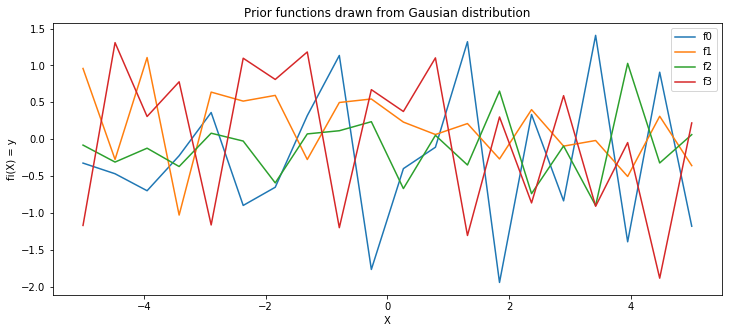

In [4]:
plot_gp_prior(4, n=20)

In [5]:
eng_tr, eng_te,  fren_tr, fren_te, y_fren_tr, y_fren_te = \
data_generator_for_gp_mimick(10000, 20, 
                             rbf_kernel, tr_percent=0.8)

NameError: name 'generate_priors' is not defined

In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self, enc_units):
        super(Encoder, self).__init__()
#         self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self, batch_sz):
        return tf.zeros((batch_sz, self.enc_units))

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, decoder_hidden, encoder_out):
        # query hidden state shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        # values shape == (batch_size, max_len, hidden size)
        # we are doing this to broadcast addition along the time axis to calculate the score
        decoder_hidden_with_time_axis = tf.expand_dims(decoder_hidden, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
            self.W1(decoder_hidden_with_time_axis) + self.W2(encoder_out)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * encoder_out
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(1)

        # used for attention
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, dec_inp, dec_hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(dec_hidden, enc_output)
        

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), tf.expand_dims(dec_inp, 1)], 
                      axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state, attention_weights

In [ ]:
optimizer = tf.keras.optimizers.Adam()

def loss_function(real, pred):
    loss_ = tf.keras.losses.mean_squared_error(real, pred)
    return tf.reduce_mean(loss_)

In [ ]:
# french_tr is the input to decoder
@tf.function
def train_step(eng_tr, fren_tr, y_fren_tr, init_enc_hidden):

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(eng_tr, init_enc_hidden)

        dec_hidden = enc_hidden

        # basically same behavior as reshape
        dec_input = tf.expand_dims(fren_tr, 1)

        predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

        loss = loss_function(y_fren_tr, predictions)

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))
    
    batch_loss(loss)

In [ ]:
@tf.function
def test_step(eng_te, fren_te, y_fren_te, batch_s):
    init_enc_hidden = encoder.initialize_hidden_state(batch_s)
    enc_output, enc_hidden = encoder(eng_te, init_enc_hidden)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims(fren_te, 1)
    predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
    loss = loss_function(y_fren_te, predictions)
    test_loss(loss)

In [ ]:
batch_loss = tf.keras.metrics.Mean(name='batch_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')

In [ ]:
tf.keras.backend.set_floatx('float32')

In [ ]:
EPOCHS = 80

for epoch in range(EPOCHS):
    start = time.time()

    batch_loss.reset_states()


    init_enc_hidden = encoder.initialize_hidden_state(128)

    for i in range(1000):
        b_eng_tr, b_fren_tr, b_y_fren_tr, _ = create_batch_gp_mim(eng_tr, fren_tr, y_fren_tr)
        train_step(b_eng_tr, b_fren_tr, b_y_fren_tr, init_enc_hidden)
        
        
        if i % 50 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   i,
                                                   batch_loss.result()))
            test_step(eng_te, fren_te, y_fren_te, eng_te.shape[0])
        
            print('Epoch {} Batch {} test Loss {:.4f}'.format(epoch + 1,
                                                   i,
                                                   test_loss.result()))

In [ ]:
encoder.trainable_variables